In [ ]:
!pip install pymatreader

In [ ]:
!pip install mne

In [ ]:
from glob import glob
import os
import mne
import numpy as np
import pandas
import matplotlib as plt
import sklearn 

In [ ]:
all_file_train_closed_h=glob('/content/drive/MyDrive/data_eye_closed_train_h/*.set')

**Data before any processing**

Reading /content/drive/MyDrive/data_eye_closed_train_h/sub-15-run-01-eye closed-01.fdt
Reading 0 ... 30029  =      0.000 ...    60.058 secs...
Opening raw-browser...


<ipython-input-46-21db0a2507bc>:2: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  dt = mne.io.read_raw_eeglab(raw,preload=True)
<ipython-input-46-21db0a2507bc>:2: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  dt = mne.io.read_raw_eeglab(raw,preload=True)
/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  c = np.array(c)


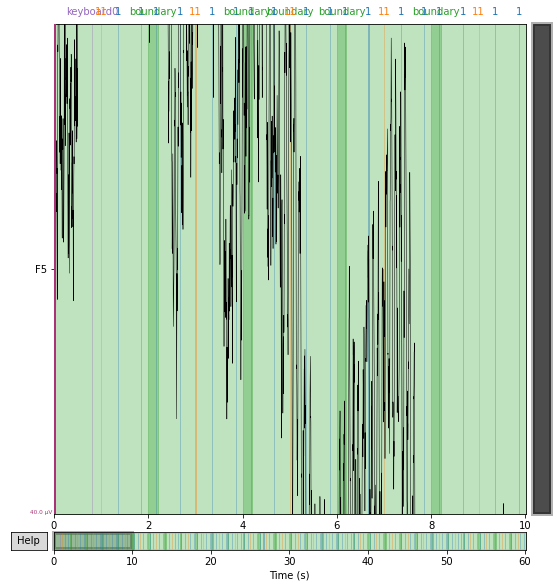

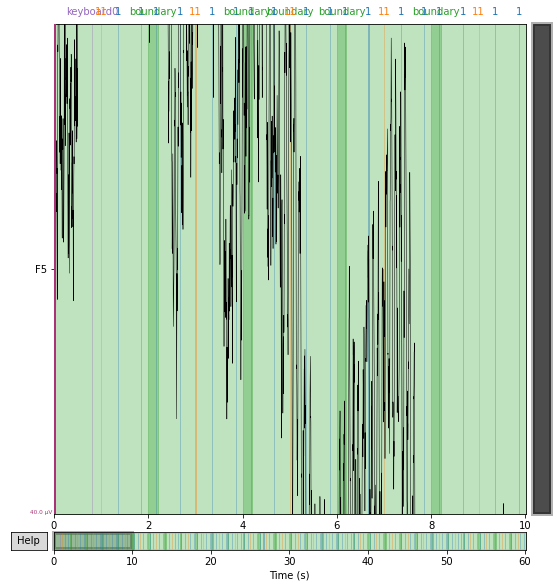

In [ ]:
raw=all_file_train_closed_h[0]
dt = mne.io.read_raw_eeglab(raw,preload=True)
dt.pick_channels(['F5'])
dt.plot()

In [ ]:
from pickle import dump
dump(dt,open('/content/drive/MyDrive/pre-processed_data/healthySub1.txt','wb'))

In [ ]:
from pickle import load
Subject_1=load(open('/content/drive/MyDrive/pre-processed_data/healthySub1.txt','rb'))

In [ ]:
def read_data(file_path):
    data = mne.io.read_raw_eeglab(file_path,preload=True)
    data.set_eeg_reference()
    data.pick_channels(['F5','HEOG','VEOG'])
    data.filter(l_freq=0.5,h_freq=50)
    data.crop(tmax=40)
    channels=data.ch_names
    if 'EKG' in channels:
        data=data.drop_channels(['EKG'])
    ica=mne.preprocessing.ICA(random_state=20)
    ica.fit(data.copy())
    data.set_channel_types({'HEOG': 'eog', 'VEOG': 'eog'})
    ica.exclude = []
# find which ICs match the ECG pattern
    eog_indices, eog_scores = ica.find_bads_eog(data,threshold=4)
#ecg_indices, ecg_scores = ica.find_bads_eog(raw,ch_name='HEOG',threshold=4)
    ica.exclude = eog_indices
    data=ica.apply(data.copy(),exclude=ica.exclude)
    #data.load_data()
    #epochs=mne.make_fixed_length_epochs(data,duration=8,overlap=0)
    return data

In [ ]:
data_processed=read_data(raw)

Reading /content/drive/MyDrive/data_eye_closed_train_h/sub-15-run-01-eye closed-01.fdt
Reading 0 ... 30029  =      0.000 ...    60.058 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 3301 samples (6.602 sec)

Fitting ICA to data using 3 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 3 components
Fitting ICA took 0.0s.
Using EOG channels: HEOG, 

<ipython-input-47-4191e8e3cc6c>:2: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  data = mne.io.read_raw_eeglab(file_path,preload=True)
<ipython-input-47-4191e8e3cc6c>:2: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  data = mne.io.read_raw_eeglab(file_path,preload=True)


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 sec)

... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 s

**Channel after processing**

Opening raw-browser...


/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  c = np.array(c)


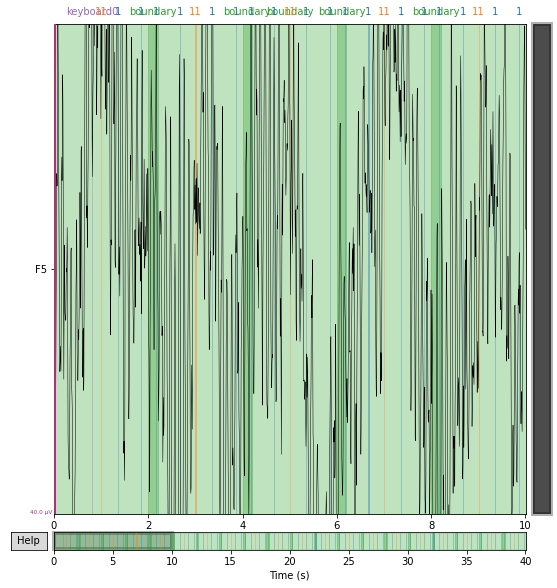

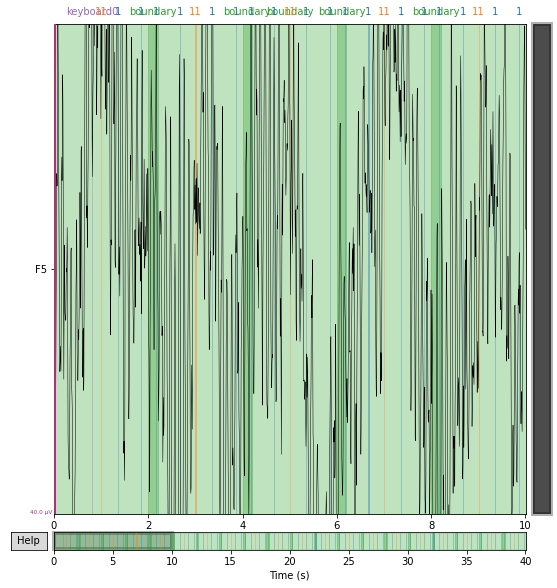

In [ ]:
data_processed.pick_channels(['F5'])
data_processed.plot()

In [ ]:
def bandpower(data, sf, band, window_sec=None, relative=False):
    from scipy.signal import welch
    from scipy.integrate import simps
    band = np.asarray(band)
    low, high = band
    
    # Define window length
    if window_sec is not None:
        nperseg = window_sec * sf
    else:
        nperseg = 4 * sf

    # Compute the modified periodogram (Welch)
    freqs, psd = welch(data, sf, nperseg=nperseg)

    # Frequency resolution
    freq_res = freqs[1] - freqs[0]

    # Find closest indices of band in frequency vector
    idx_band = np.logical_and(freqs >= low, freqs <= high)

    # Integral approximation of the spectrum using Simpson's rule.
    bp = simps(psd[idx_band], dx=freq_res)

    if relative:
        bp /= simps(psd, dx=freq_res)
    return bp

In [ ]:
def power_calculation(data):
  power_feature=[]
  samplerate = 500
  band_theta = [4, 8]
  band_alpha = [8, 12]
  band_beta = [12, 30]
  band_gamma = [30, 45]
  power_theta=bandpower(data,samplerate,band_theta)
  power_alpha=bandpower(data,samplerate,band_alpha)
  power_beta=bandpower(data,samplerate,band_beta)
  power_gama=bandpower(data,samplerate,band_gamma)
  power_feature.append(power_theta)
  power_feature.append(power_alpha)
  power_feature.append(power_beta)
  power_feature.append(power_gama)
  return power_feature

In [ ]:
vlt_data=data_processed.get_data() #to get the signal as an array of voltages 
power=power_calculation(vlt_data[0])
print(power)

[1.1772986685599083e-11, 5.3353458934965647e-11, 8.556115226828481e-12, 2.30111908731954e-12]
